In [1]:
%matplotlib inline
import mhkit
import gridstatus
import numpy as np
import pandas as pd
import requests
import io
import matplotlib.pyplot as plt
import PySAM.Pvwattsv8 as pv
import PySAM.Windpower as wd

In [2]:
# NDBC data
ndbc_data_file = 'NDBC-46022-2021-spectrum.txt'
# downloaded from https://www.ndbc.noaa.gov/download_data.php?filename=46022w2021.txt.gz&dir=data/historical/swden/
[wave_data,meta] = mhkit.wave.io.ndbc.read_file(ndbc_data_file)
depth = 419 # m
J = mhkit.wave.resource.energy_flux(wave_data.T,depth) # energy flux, W/m


In [3]:
# SAM wave 3-hourly data
url = 'https://raw.githubusercontent.com/NREL/SAM/develop/deploy/wave_resource_ts/lat40.84_lon-124.25__2010.csv'
download = requests.get(url).content
file = io.StringIO(download.decode('utf-8'))
parser = lambda y,m,d,H,M: pd.datetime.strptime(f"{y}.{m}.{d}.{H}.{M}", "%Y.%m.%d.%H.%M")

wave_data_2 = pd.read_csv(file, skiprows = 2, parse_dates={"Time":[0,1,2,3,4]}, date_parser=parser)
wave_data_2 = wave_data_2[['Time','Significant Wave Height','Energy Period']].set_index("Time")
wave_data_2.index = wave_data_2.index.tz_localize('US/Pacific') + pd.offsets.DateOffset(years=11) # fake it starting in 2021
wave_data_2.head()

,Significant Wave Height,Energy Period
Time,,
2021-01-01 00:00:00-08:00,3.21103,9.0149
2021-01-01 03:00:00-08:00,3.13325,9.2803
2021-01-01 06:00:00-08:00,3.32286,8.8879
2021-01-01 09:00:00-08:00,3.35948,8.8694
2021-01-01 12:00:00-08:00,3.33115,9.3399


In [4]:
# Wave energy time series calculation
rho = 1025
g = 9.8
coeff = rho*(g**2)/(64*np.pi)
wave_data_2["J"] = coeff*wave_data_2["Significant Wave Height"]**2*wave_data_2["Energy Period"]
CW = 10 # capture width of WEC, m
wave_data_2["P"] = wave_data_2["J"] * CW # power of WEC, W

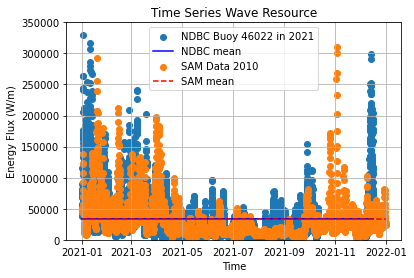

In [5]:
# plot NDBC data alongside SAM data
fig, ax = plt.subplots()

ax.scatter(J.index, J["J"], label='NDBC Buoy 46022 in 2021')
ax.plot(J.index, np.full(np.shape(J.index),J.mean(axis=0)), c='blue', label='NDBC mean')

#plt.xlim([J.index[0], J.index[24]])
plt.ylim([0, 350000])
ax.scatter(wave_data_2.index, wave_data_2["J"], label='SAM Data 2010')
ax.plot(wave_data_2.index, np.full(np.shape(wave_data_2["J"]),wave_data_2["J"].mean(axis=0)), '--', c='red', label='SAM mean')

ax.legend()
ax.set(xlabel='Time', ylabel='Energy Flux (W/m)', title='Time Series Wave Resource')
ax.grid()


In [6]:
# CAISO data
caiso = gridstatus.CAISO()
start = pd.Timestamp("Jan 1, 2021").normalize()
end = pd.Timestamp("Dec 31, 2021").normalize()
#lmp = caiso.get_lmp(start=start, end=end, market='REAL_TIME_HOURLY', 
#                    locations=["EUREKAA_6_N001"])
lmp = pd.read_csv('lmp-eureka-2021.csv',index_col=1)
lmp.index = pd.to_datetime(lmp.index,utc=True).tz_convert('US/Pacific')


(0.0, 50.0)

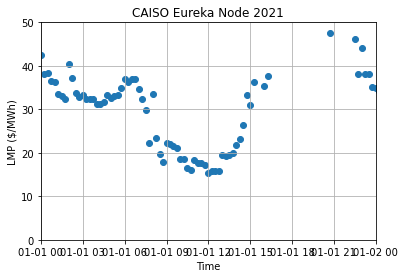

In [7]:
# plot CAISO data
fig, ax = plt.subplots()
ax.scatter(lmp.index, lmp["LMP"])
ax.set(xlabel='Time', ylabel='LMP ($/MWh)', title='CAISO Eureka Node 2021')
ax.grid()
plt.xlim([lmp.index[0], lmp.index[24*4]])
plt.ylim([0,50])

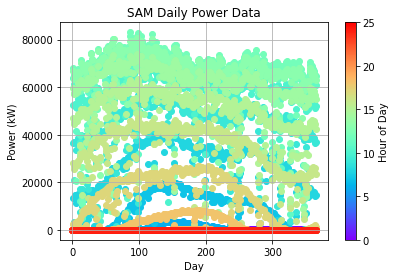

In [8]:
# Get solar data
file = 'imperial_ca_32.835205_-115.572398_psmv3_60_tmy.csv'
# downloaded from https://raw.githubusercontent.com/NREL/SAM/patch/deploy/solar_resource/imperial_ca_32.835205_-115.572398_psmv3_60_tmy.csv

system_model = pv.default("PVWattsNone")
system_model.SolarResource.solar_resource_file = file
system_model.execute()
energy = system_model.value('annual_energy_distribution_time')

# plot daily power
fig, ax = plt.subplots()
for year in range(0,len(energy)):
    ax.scatter(energy[0],energy[year],color=plt.cm.rainbow(year/len(energy)))
ax.set(xlabel='Day', ylabel='Power (kW)', title='SAM Daily Power Data')
ax.grid()
plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0,vmax=len(energy)), cmap='rainbow'),ax=ax,label='Hour of Day')

,P
2021-01-01 00:00:00-08:00,0.000000e+00
2021-01-01 01:00:00-08:00,0.000000e+00
2021-01-01 02:00:00-08:00,0.000000e+00
2021-01-01 03:00:00-08:00,0.000000e+00
2021-01-01 04:00:00-08:00,0.000000e+00
2021-01-01 05:00:00-08:00,0.000000e+00
2021-01-01 06:00:00-08:00,0.000000e+00
2021-01-01 07:00:00-08:00,1.341493e+07
2021-01-01 08:00:00-08:00,3.661477e+07
2021-01-01 09:00:00-08:00,5.238607e+07


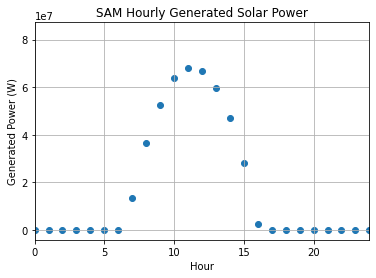

In [9]:
# plot hourly generated solar power
gen = system_model.value('ac')
fig, ax = plt.subplots()
ax.scatter(range(0,len(gen)),gen)
ax.set(xlabel='Hour', ylabel='Generated Power (W)', title='SAM Hourly Generated Solar Power')
ax.grid()
plt.xlim([0, 24])

time = pd.date_range(pd.Timestamp('1/1/2021',tz='US/Pacific'), freq='H', periods=len(gen))
solar_data = pd.DataFrame(gen,index=time,columns=["P"])
solar_data.head(10)

,P
2021-01-01 00:00:00-08:00,1.785906e+07
2021-01-01 01:00:00-08:00,1.804262e+07
2021-01-01 02:00:00-08:00,1.890357e+07
2021-01-01 03:00:00-08:00,2.032370e+07
2021-01-01 04:00:00-08:00,1.071414e+07
2021-01-01 05:00:00-08:00,4.572321e+06
2021-01-01 06:00:00-08:00,9.532408e+06
2021-01-01 07:00:00-08:00,9.979421e+06
2021-01-01 08:00:00-08:00,8.567337e+06
2021-01-01 09:00:00-08:00,8.005475e+06


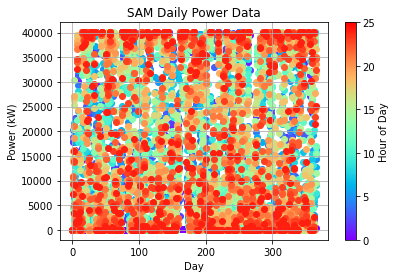

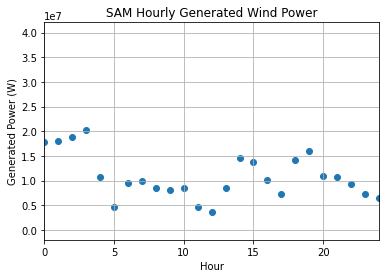

In [10]:
# Get wind data
# downloaded from https://raw.githubusercontent.com/NREL/SAM/patch/deploy/wind_resource/CA%20Northern-Ocean.srw
file = 'CA Northern-Ocean.srw'

system_model = wd.default("WindPowerNone")
system_model.Resource.wind_resource_filename = file
system_model.execute()
energy = system_model.value('annual_energy_distribution_time')

fig, ax = plt.subplots()
for year in range(0,len(energy)):
    ax.scatter(energy[0],energy[year],color=plt.cm.rainbow(year/len(energy)))
ax.set(xlabel='Day', ylabel='Power (kW)', title='SAM Daily Power Data')
ax.grid()
plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0,vmax=len(energy)), cmap='rainbow'),ax=ax,label='Hour of Day')

# plot hourly generated wind power
gen = np.array(system_model.value('gen'))*1000
fig, ax = plt.subplots()
ax.scatter(range(0,len(gen)),gen)
ax.set(xlabel='Hour', ylabel='Generated Power (W)', title='SAM Hourly Generated Wind Power')
ax.grid()
plt.xlim([0, 24])

time = pd.date_range(pd.Timestamp('1/1/2021',tz='US/Pacific'), freq='H', periods=len(gen))
wind_data = pd.DataFrame(gen,index=time,columns=["P"])
wind_data.head(10)


In [11]:
# Create overall dataframe with all resources resampled onto consistent times,
# accounting for different end times across datasets

dfs = [lmp, wave_data_2, solar_data, wind_data]
# todo: something is wrong with the interpolation!
dfs_resampled = [df.resample('15min').mean().interpolate() for df in dfs]
#print(dfs_resampled)

end_times = [df.index[-1] for df in dfs_resampled]
idx = np.argmin(end_times)
df = pd.DataFrame(index=dfs_resampled[idx].index)

df["LMP ($/MWh)"] = dfs_resampled[0]["LMP"]
df["Wave power (W)"] = dfs_resampled[1]["P"]
df["Solar power (W)"] = dfs_resampled[2]["P"]
df["Wind power (W)"] = dfs_resampled[3]["P"]
df.head()

,LMP ($/MWh),Wave power (W),Solar power (W),Wind power (W)
Time,,,,
2021-01-01 00:00:00-08:00,42.40946,455088.458529,0.0,1.785906e+07
2021-01-01 00:15:00-08:00,38.19612,454336.515662,0.0,1.790495e+07
2021-01-01 00:30:00-08:00,38.39243,453584.572795,0.0,1.795084e+07
2021-01-01 00:45:00-08:00,36.49474,452832.629928,0.0,1.799673e+07
2021-01-01 01:00:00-08:00,36.37271,452080.687061,0.0,1.804262e+07


(18628.333333333332, 18629.333333333332)

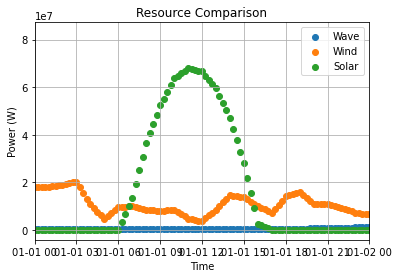

In [12]:
# plot resampled data to confirm interpolation works
resources = ['Wave','Wind','Solar']
powers = [r + ' power (W)' for r in resources]

fig, ax = plt.subplots()
for i in range(0,len(resources)):
    ax.scatter(df.index, df[powers[i]], label=resources[i])
ax.set(xlabel='Time', ylabel='Power (W)', title='Resource Comparison')
ax.grid()
ax.legend()
plt.xlim([df.index[0], df.index[4*24]])

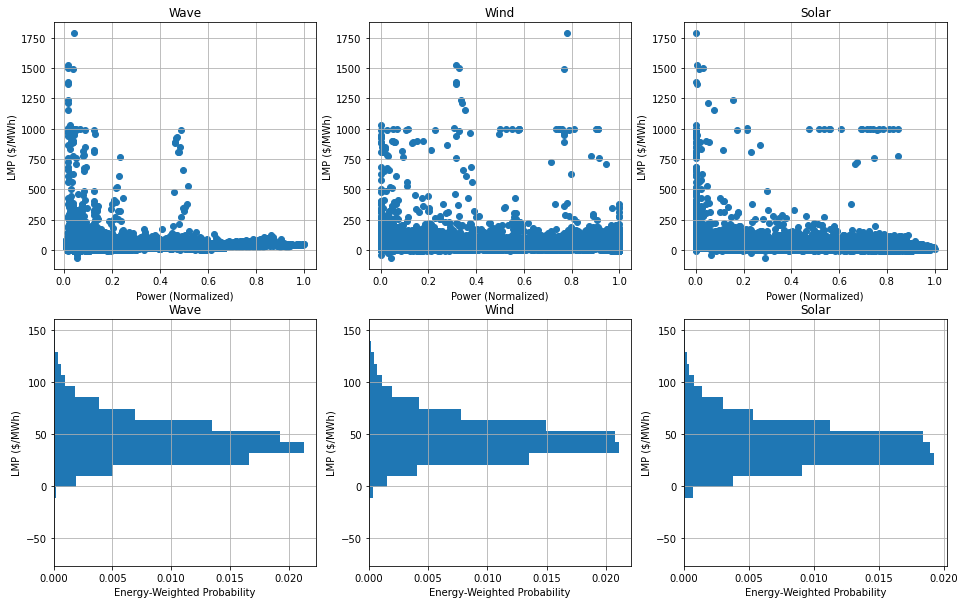

In [17]:
# scatterplot correlation between production and price
fig, axs = plt.subplots(ncols=len(resources),nrows=2,figsize=(16,10))
for i in range(0,len(resources)):
    axs[0,i].scatter(df[powers[i]]/df[powers[i]].max(), df["LMP ($/MWh)"])
    axs[0,i].set(xlabel='Power (Normalized)', ylabel='LMP ($/MWh)', title=resources[i])
    axs[0,i].grid()
    yrange = [df["LMP ($/MWh)"].min(), 150]
    axs[1,i].hist(df["LMP ($/MWh)"],weights=df[powers[i]]/df[powers[i]].max(),range=yrange,orientation='horizontal',density=True,bins=20)
    axs[1,i].set(xlabel='Energy-Weighted Probability',ylabel='LMP ($/MWh)',title=resources[i])
    axs[1,i].grid()
fig.suptitle = 'Correlation between production and price'

In [ ]:
# value of each energy source
W_to_MWh = 15/60 * 10**-6 # for 15min timestep
revenue = W_to_MWh * np.dot(df[powers].T, df["LMP ($/MWh)"])
energy = W_to_MWh * df[powers].sum()
energy.reset_index(drop=True,inplace=True)
value = np.divide(revenue,energy)

output = pd.DataFrame(np.vstack([revenue,energy,value]).T, index=resources, columns=['Yearly Revenue ($)','Yearly Energy (MWh)','Value ($/MWh)'])
output['Yearly Revenue ($)'] = output['Yearly Revenue ($)'].map(lambda x: f"${x:,.2f}") # format as currency
print(output)
